### Докинг низкомолекулярных лигандов в структуру белка

In [1]:
import numpy as np
import copy

from IPython.display import display, display_svg, SVG, Image

import oddt
import oddt.docking
import oddt.interactions

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import pmx

Загрузим файл с результатом моделирования, полученный в предыдущем ДЗ.

In [2]:
pdb = pmx.Model('with_ligand.B99990001.pdb')
for r in pdb.residues[-7:]:
    print(r)

<Molecule: id = 144 name = GLY chain_id =    natoms = 4>
<Molecule: id = 145 name = CYS chain_id =    natoms = 6>
<Molecule: id = 146 name = HIS chain_id =    natoms = 10>
<Molecule: id = 147 name = LEU chain_id =    natoms = 9>
<Molecule: id = 148 name = NDG chain_id =    natoms = 15>
<Molecule: id = 149 name = NAG chain_id =    natoms = 14>
<Molecule: id = 150 name = NAG chain_id =    natoms = 14>


Последние три остатка - это лиганд. Разделим белок и лиганд и сохраним в <b>.pdb</b> файлы.

In [3]:
protein = pdb.copy()
for r in protein.residues[-3:]:
    protein.remove_residue(r)
print 'amount of protein residues is', len(protein.residues)
protein.writePDB('protein.pdb')

ligand = pdb.copy()
del ligand.residues[:-3]
print 'amount of ligand residues is', len(ligand.residues)
ligand.writePDB('NAG.pdb')

amount of protein residues is 147
amount of ligand residues is 3


Найдем геометрический центр лиганда.

In [4]:
s = np.zeros(3)
for atom in ligand.atoms:
    s += atom.x

center = s / len(ligand.atoms)
print center

[40.08093453 28.99619394 26.04091162]


Загрузим белок для докинга.

In [5]:
prot = oddt.toolkit.readfile('pdb','protein.pdb').next()

prot.OBMol.AddPolarHydrogens()
prot.OBMol.AutomaticPartialCharge()

print 'is it the first mol in 1lmp is protein?', prot.protein,':) and MW of this mol is:', prot.molwt 

is it the first mol in 1lmp is protein? False :) and MW of this mol is: 16831.041


Создадим функцию, которая отрисует лиганд, а затем проведет докинг и сохранит результат в виде <b>.pdb</b> файла.

In [6]:
def draw_docking_res(center, prot, smile):
    m = oddt.toolkit.readstring('smi', smile)
    
    if not m.OBMol.Has3D(): 
        m.make3D(forcefield = 'mmff94', steps = 150)
        m.removeh()
        m.OBMol.AddPolarHydrogens()
    
    display_svg(SVG(copy.deepcopy(m).write('svg')))    
    
    xx = center[0]
    yy = center[1]
    zz = center[2]

    docking_object = oddt.docking.AutodockVina.autodock_vina(protein = prot,
                                                             size = (20, 20, 20),
                                                             center = [xx, yy, zz],
                                                             executable = '/usr/bin/vina', 
                                                             autocleanup = True, 
                                                             num_modes = 5) # количество моделей уменьшим до 5

    print docking_object.tmp_dir
    print " ".join(docking_object.params)
    
    res = docking_object.dock([m], prot)

    for i, r in enumerate(res):
        hbs = oddt.interactions.hbonds(prot, r)
        stack = oddt.interactions.pi_stacking(prot, r)
        phob = oddt.interactions.hydrophobic_contacts(prot, r)
    
    print
    print ' #', '  formula', 'affinity', 'rmsd', 'res name'
    for i, r in enumerate(res):
        r.write(filename = smile + 'r%s.pdb' % i, format = 'pdb')
        print "%2d%10s%6s%8s%5s" %(i, 
                                   r.formula, 
                                   r.data['vina_affinity'],  
                                   r.data['vina_rmsd_ub'], 
                                   r.residues[0].name)

Запустим программу для перечисленных лигандов.

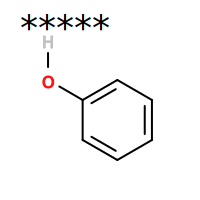

/tmp/autodock_vina_xH6pvT
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0     C6H6O  -4.3   0.000  UNL
 1     C6H6O  -4.2   1.829  UNL
 2     C6H6O  -4.1   2.416  UNL
 3     C6H6O  -4.1   1.995  UNL
 4     C6H6O  -4.0   1.610  UNL


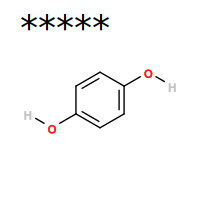

/tmp/autodock_vina_UyKFj0
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0    C6H6O2  -4.2   0.000  UNL
 1    C6H6O2  -4.2   3.656  UNL
 2    C6H6O2  -4.2   1.714  UNL
 3    C6H6O2  -4.1   3.326  UNL
 4    C6H6O2  -4.0   6.368  UNL


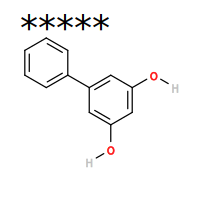

/tmp/autodock_vina_S3nk_o
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0  C12H10O2  -6.7   0.000  UNL
 1  C12H10O2  -6.6   2.189  UNL
 2  C12H10O2  -6.3   2.924  UNL
 3  C12H10O2  -6.3   2.336  UNL
 4  C12H10O2  -6.3   5.812  UNL


In [8]:
smiles = ['c1cccc(O)c1', 'c1c(O)ccc(O)c1','c1(O)cc(c2ccccc2)cc(O)c1']

for smile in smiles:
    draw_docking_res(center, prot, smile)

Лучше всего подходит лиганд, содержащий фенильную группу: у него самая низкая аффинность из трех. Выберем вариант докингда с наименьшим RMSD и визуализируем.

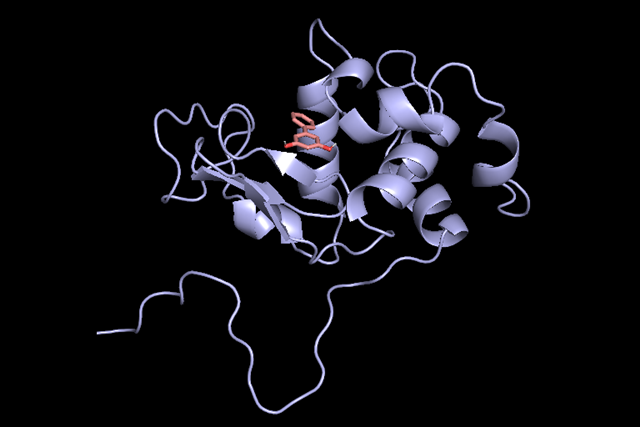

In [9]:
Image('test_ligand.png')

А так выглядят два других. Они достаточно маленькие, поэтому, вероятно, более низкая аффинность: условно говоря, им сложно зацепиться.

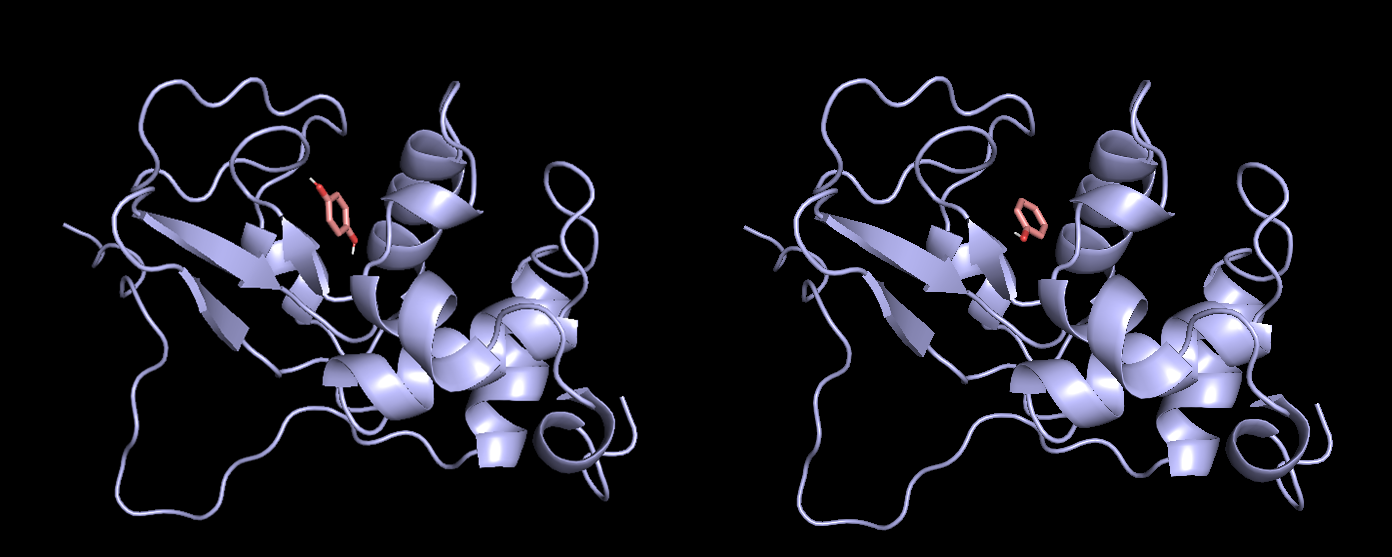

In [10]:
Image('other_ligands.png')

Запустим программу для модифицированных лигандов NAG.

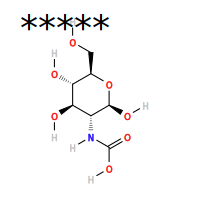

/tmp/autodock_vina_L4lWGf
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0  C7H13NO7  -5.6   0.000  UNL
 1  C7H13NO7  -4.8   4.868  UNL
 2  C7H13NO7  -4.7   5.173  UNL
 3  C7H13NO7  -4.7   5.128  UNL
 4  C7H13NO7  -4.6   4.458  UNL


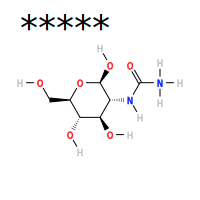

/tmp/autodock_vina_4FXzM8
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0 C7H16N2O6  -5.6   0.000  UNL
 1 C7H16N2O6  -5.5   5.183  UNL
 2 C7H16N2O6  -5.3   3.525  UNL
 3 C7H16N2O6  -5.1   1.569  UNL
 4 C7H16N2O6  -5.0   5.553  UNL


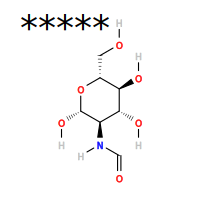

/tmp/autodock_vina_QtyIyO
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0  C7H13NO6  -5.3   0.000  UNL
 1  C7H13NO6  -4.9   3.481  UNL
 2  C7H13NO6  -4.8   5.134  UNL
 3  C7H13NO6  -4.6   3.124  UNL
 4  C7H13NO6  -4.6   4.690  UNL


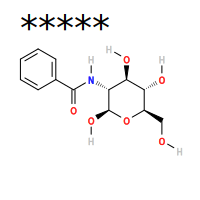

/tmp/autodock_vina_78tz_U
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0 C13H17NO6  -7.0   0.000  UNL
 1 C13H17NO6  -5.9   6.587  UNL
 2 C13H17NO6  -5.7   6.494  UNL
 3 C13H17NO6  -5.6   3.420  UNL
 4 C13H17NO6  -5.5   2.346  UNL


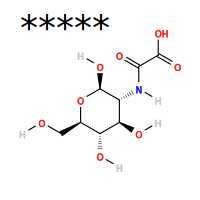

/tmp/autodock_vina_MfVsRz
--center_x 40.080934533551535 --center_y 28.99619394435352 --center_z 26.040911620294583 --size_x 20 --size_y 20 --size_z 20 --cpu 1 --exhaustiveness 8 --num_modes 5 --energy_range 3

 #   formula affinity rmsd res name
 0  C8H13NO8  -5.9   0.000  UNL
 1  C8H13NO8  -5.4   5.674  UNL
 2  C8H13NO8  -5.3   6.310  UNL
 3  C8H13NO8  -5.1   4.510  UNL
 4  C8H13NO8  -5.0   5.752  UNL


In [11]:
smiles = ['OC(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',
          '[NH3+]C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O',
          'C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O', 
          'C1=C[C]=CC=C1C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O', 
          '[O-]C(=O)C(=O)N[C@H]1[C@H](O)O[C@H](CO)[C@@H](O)[C@@H]1O']

for smile in smiles:
    draw_docking_res(center, prot, smile)

В этот раз наименьшая аффинность тоже у лиганда, содержащего фенильную группу. Снова возьмём вариант с нулевым RMSD и визуализируем.

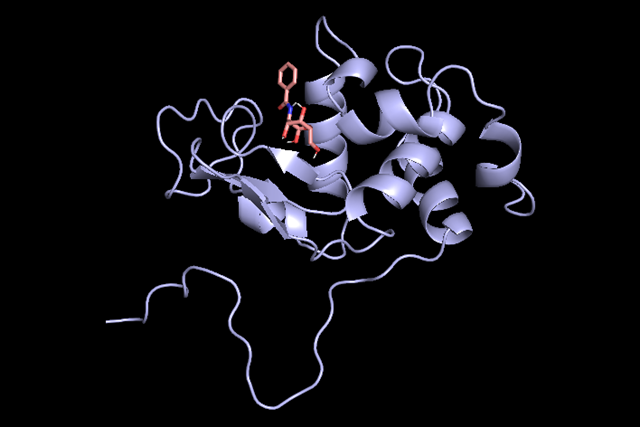

In [12]:
Image('ph_ligand.png')

Результаты докинга лигандов от лучшего к худшему:
- NAG + фенильная группа
- NAG + карбоксильная группа
- NAG + аминогруппа
- NAG + гидроксильная группа
- NAG + водород

Вероятно, такой результат тоже связан с размером радикала, а также зарядом: положительно заряженая аминогруппа имеет результат хуже, чем отрицательно заряженная карбоксильная.

Поскольку все эти лиганды - лишь модификация NAG, расположены они практически идентично.

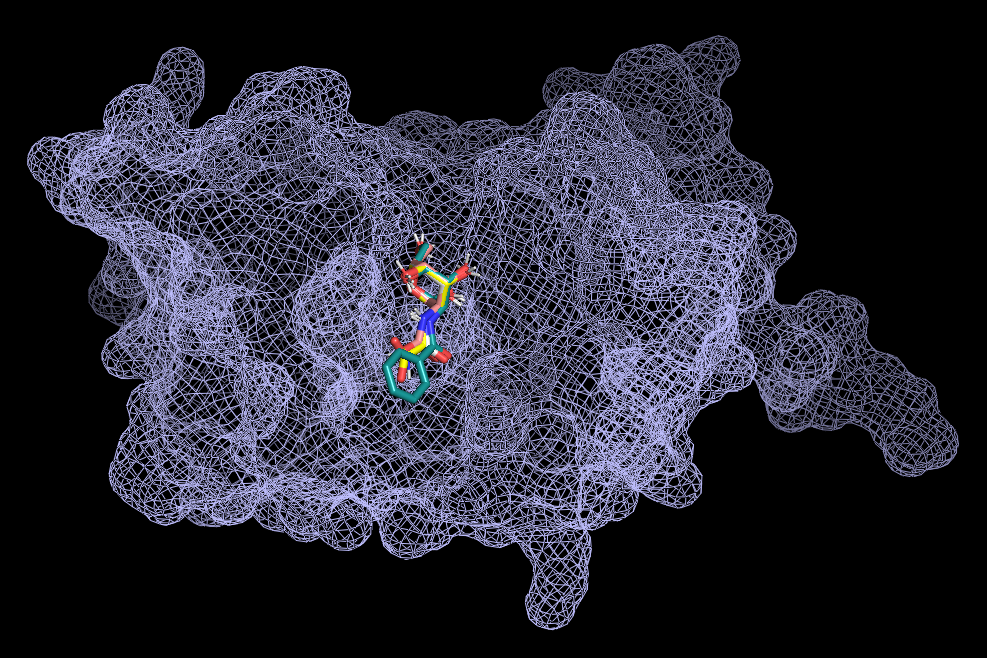

In [13]:
Image('all_mesh_up.png')

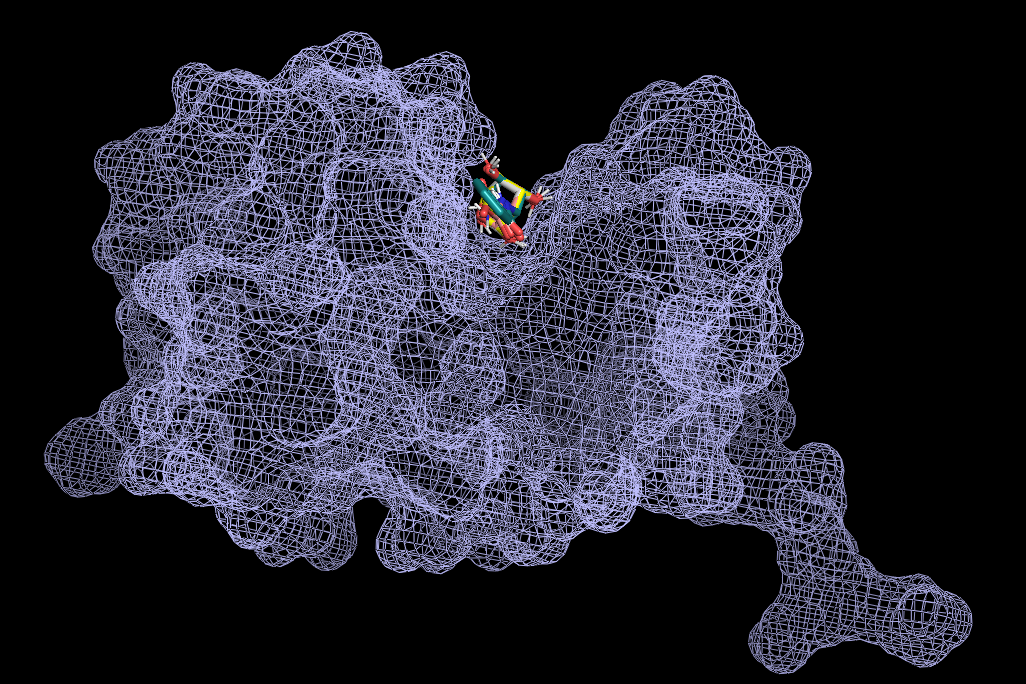

In [14]:
Image('all_mesh.png')